In [77]:
import pandas as pd
import numpy as np
from itertools import chain
import patsy
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import colorcet as cc
%matplotlib inline

In [78]:
from IPython.display import display
pd.set_option('display.max_rows', 1000)

In [79]:
todrop = ["X1249", "X134", "X1369", "X137", "X1379", "X1389", "X1418_2", "X1428_3", "X1707_2", "X1717", "X20002_1220", "X20116_0", "X20116_1", "X20126_3", "X20126_4", "X20126_5", "X20524", "X22506_114", "X22617_4217", "X24007", "X41248_1000", "X6138_100", "X6139_100", "X6140_100", "X6144_5", "X6145_100", "X6146_2", "X6146_3", "X6148_100", "X6148_2", "X6148_4", "X6149_100", "X6150_100", "X6152_100", "X6154_1", "X6154_100", "X6154_2", "X6154_3", "X6154_4", "X6154_5", "X6155_100", "X6159_100", "X6160_100", "X6179_100", "X680_2", "X680_4", "X709","X6146_100","X6142_4","X20126_0","X20003_1140884600","X1448_3","X20411_1","X20405_1","X680_3"]

In [80]:
datacov = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/TRAINING/redux10point2/for_jupyter/datacov.csv').drop("Unnamed: 0",axis=1)
modelcov = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/TRAINING/redux10point2/for_jupyter/modelcov.csv').drop("Unnamed: 0",axis=1)

In [81]:
dimnames = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/TRAINING/redux10point2/for_jupyter/dimnames.csv',header=None).drop(0)

datacov.index = dimnames[1].values
modelcov.index = dimnames[1].values
datacov.columns = dimnames[1].values
modelcov.columns = dimnames[1].values

In [82]:
difference = abs(datacov - modelcov)

In [83]:
#prepare factor dataframe
factors = pd.read_table("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/test_absfin_fin_loadings_fin_convcheck_orig_minres_36_withsmc_allgt0.1.txt",header=None,names=['fieldname','factornum','loading'])
fieldnamedict = pd.read_table("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/phenos730_fields.tsv")
phenosummary = pd.read_table("/stanley/robinson/ccarey/UKBB/ukb_files/phenotypes.both_sexes.tsv")
#covars = pd.read_csv("/psych/genetics_data/projects/ukbb_sexdiff/family_based/ukb31063_fullsample_covariates.csv",index_col="s")

factors["item"] = factors.fieldname.apply(lambda x: "X"+fieldnamedict[fieldnamedict["name"]==x].fieldID.values[0])
factors["factor"] = factors.factornum.apply(lambda x: "f"+str(x))

factors_efa = factors.copy()

phenosummary["phenotype"] = phenosummary.apply(lambda x: "41202_"+x.phenotype if (x.source=="icd10") else x.phenotype,axis=1)

factors["type"] = factors.item.apply(lambda x: phenosummary[(("X"+phenosummary["phenotype"])==x) | (("X"+phenosummary["phenotype"])==x+"_raw")].variable_type.values[0])
factors["ordered"] = factors.apply(lambda x: 0 if x.type=="continuous_raw" else 1,axis=1)

In [84]:
#prepare correlation dataframes
cormat = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL/COR.csv').drop("Unnamed: 0",axis=1)
varnames = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL/varnames.csv',header=None).drop(0)

cormat.columns = varnames[1].values
cormat.index = varnames[1].values

phenoNames = pd.read_csv("/psych/genetics_data/ccarey/UKBB/factor_gwas/core_data_group/FA_core_FieldNames.csv",index_col="Unnamed: 0")

phenolabels = pd.Series(phenoNames["name"],index=phenoNames.index).to_dict()

abs_cormat = abs(cormat)

abs_cormat["fieldname"] = [phenolabels[x[1:]] for x in abs_cormat.index]

phenodata = pd.read_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/MI/core_data.csv",index_col="userId")

nonmiss = phenodata.notnull()

phenodata.columns = ["X"+x for x in phenodata.columns]

nonmiss.columns = ["X"+x for x in nonmiss.columns]

nomissdict = nonmiss.sum().to_dict()

abs_cormat["nonmiss"] = [nomissdict[x] for x in abs_cormat.index]

In [85]:
#removals
factors = factors[~factors.item.isin(todrop)]

abs_cormat = abs_cormat.loc[~abs_cormat.index.isin(todrop),~abs_cormat.columns.isin(todrop)]

In [86]:
#come back to this at some point... 
factors = factors[~(factors.factor=="f8")]

In [87]:
#number of remaining items, down from 564
len(factors.item.unique())

505

In [88]:
#add in current cfa loadings
cfafactors = pd.read_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/TRAINING/redux10point2/for_jupyter/loadings.txt",sep="\t")
factors = factors.sort_values(["factor","item"])
factors["cfaloading"]=cfafactors.loading.values
factors["cfaloading_abs"]=abs(cfafactors.loading.values)

In [89]:
factordict = factors.groupby('factor')["item"].apply(lambda x: x.tolist()).to_dict()

In [90]:
phenostructure = pd.read_csv('/stanley/genetics/analysis/ukbb_ldsc_round2/reference/Data_Dictionary_Showcase.csv',index_col="FieldID")

In [91]:
factors["origin"] = factors["item"].apply(lambda x: phenostructure.loc[int(x.split("_")[0][1:]),"Path"])

In [92]:
factors.drop_duplicates("item").origin.value_counts()

Online follow-up > Work environment > Employment history                                                                   55
UK Biobank Assessment Centre > Touchscreen > Psychosocial factors > Mental health                                          33
UK Biobank Assessment Centre > Verbal interview > Medications                                                              29
UK Biobank Assessment Centre > Touchscreen > Lifestyle and environment > Diet                                              29
Health-related outcomes > Hospital in-patient > Diagnoses > Summary Information (diagnoses)                                27
UK Biobank Assessment Centre > Touchscreen > Lifestyle and environment > Physical activity                                 20
Online follow-up > Mental health > Traumatic events                                                                        18
UK Biobank Assessment Centre > Touchscreen > Health and medical history > Medication                                  

In [93]:
categorydict = pd.read_table("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/newcode/figure1/categorydict_type.tsv", sep="\t")

In [94]:
mycatdict = dict(zip(categorydict.treestruct,categorydict.category))
#dict(categorydict.groupby("category")["treestruct"].apply(list))

In [95]:
categories = pd.DataFrame(index=factors.drop_duplicates("item").item.values,data=factors.drop_duplicates("item").origin.apply(lambda x: mycatdict[x]).values).reset_index()
categories.columns=["item","category"]
# categories.to_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/newcode/figure1/categories_type.csv",index=False)

In [96]:
total = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/newcode/figure1/FS_total.csv').set_index("Unnamed: 0")
factors = total.columns
total.columns = [x+"_total" for x in total.columns]

In [97]:
for i in range(6):
    i=i+1
    temp = pd.read_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/newcode/figure1/FS_cattype_"+str(i)+".csv").set_index("Unnamed: 0")
    temp.columns = [x+"_cat"+str(i) for x in temp.columns]
    total = total.join(temp,how="left")

In [98]:
# total.to_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/newcode/figure1/FS_cattype_all.csv")

In [99]:
phenoNames = pd.read_csv("/psych/genetics_data/ccarey/UKBB/factor_gwas/core_data_group/FA_core_FieldNames.csv",index_col="Unnamed: 0")
phenolabels = pd.Series(phenoNames["name"],index=phenoNames.index).to_dict()

In [100]:
top2 = pd.read_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/newcode/figure1/topitems_labels_short.csv")

In [101]:
#topitems["labels"] = topitems.item.apply(lambda x: phenolabels[x[1:]]).values

In [102]:
#top2 = topitems[topitems["rank"]<3]

In [103]:
factorlabels = pd.DataFrame(top2.groupby("factor")["labels"].apply(list))

In [104]:
factorlabels["fulllabel"] = factorlabels.apply(lambda x: x.labels[0]+"\n"+x.labels[1],axis=1)

In [105]:
#top2.to_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/newcode/figure1/topitems_labels_short.csv")

In [106]:
factorlabels

,labels,fulllabel
factor,,
f1,"[Recent inability to stop or control worrying,...",Recent inability to stop or control worrying\n...
f10,"[College or University degree, Year ended full...",College or University degree\nYear ended full ...
f11,"[Doctor diagnosed asthma, Blood clot, ..., all...","Doctor diagnosed asthma\nBlood clot, ..., alle..."
f12,"[Vascular/heart problems: High blood pressure,...",Vascular/heart problems: High blood pressure\n...
f13,"[Mineral & dietary supplements: Fish oil, Mine...",Mineral & dietary supplements: Fish oil\nMiner...
f14,"[Long-standing illness, disability or infirmit...","Long-standing illness, disability or infirmity..."
f15,"[People in household: Husband, wife or partner...","People in household: Husband, wife or partner\..."
f16,"[Vascular/heart problems: Heart attack, Main I...",Vascular/heart problems: Heart attack\nMain IC...
f17,"[Number of jobs held, Workplace very noisy: Ra...",Number of jobs held\nWorkplace very noisy: Rar...


In [107]:
factorlabels.loc["f1","labels"][0]+"\n"+factorlabels.loc["f1","labels"][1]

'Recent inability to stop or control worrying\nRecent worrying too much about different things'

In [108]:
pctvar = pd.read_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/newcode/figure1/pctvar_hierparttype.csv").set_index("Unnamed: 0")

In [109]:
catkey = pd.read_table("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/newcode/figure1/categorykey_type.tsv")

catkey = dict(zip(catkey.catnum,catkey.catname))

pctvar.index = catkey.values()

In [110]:
pctvar.columns = [x.upper() for x in pctvar.columns]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


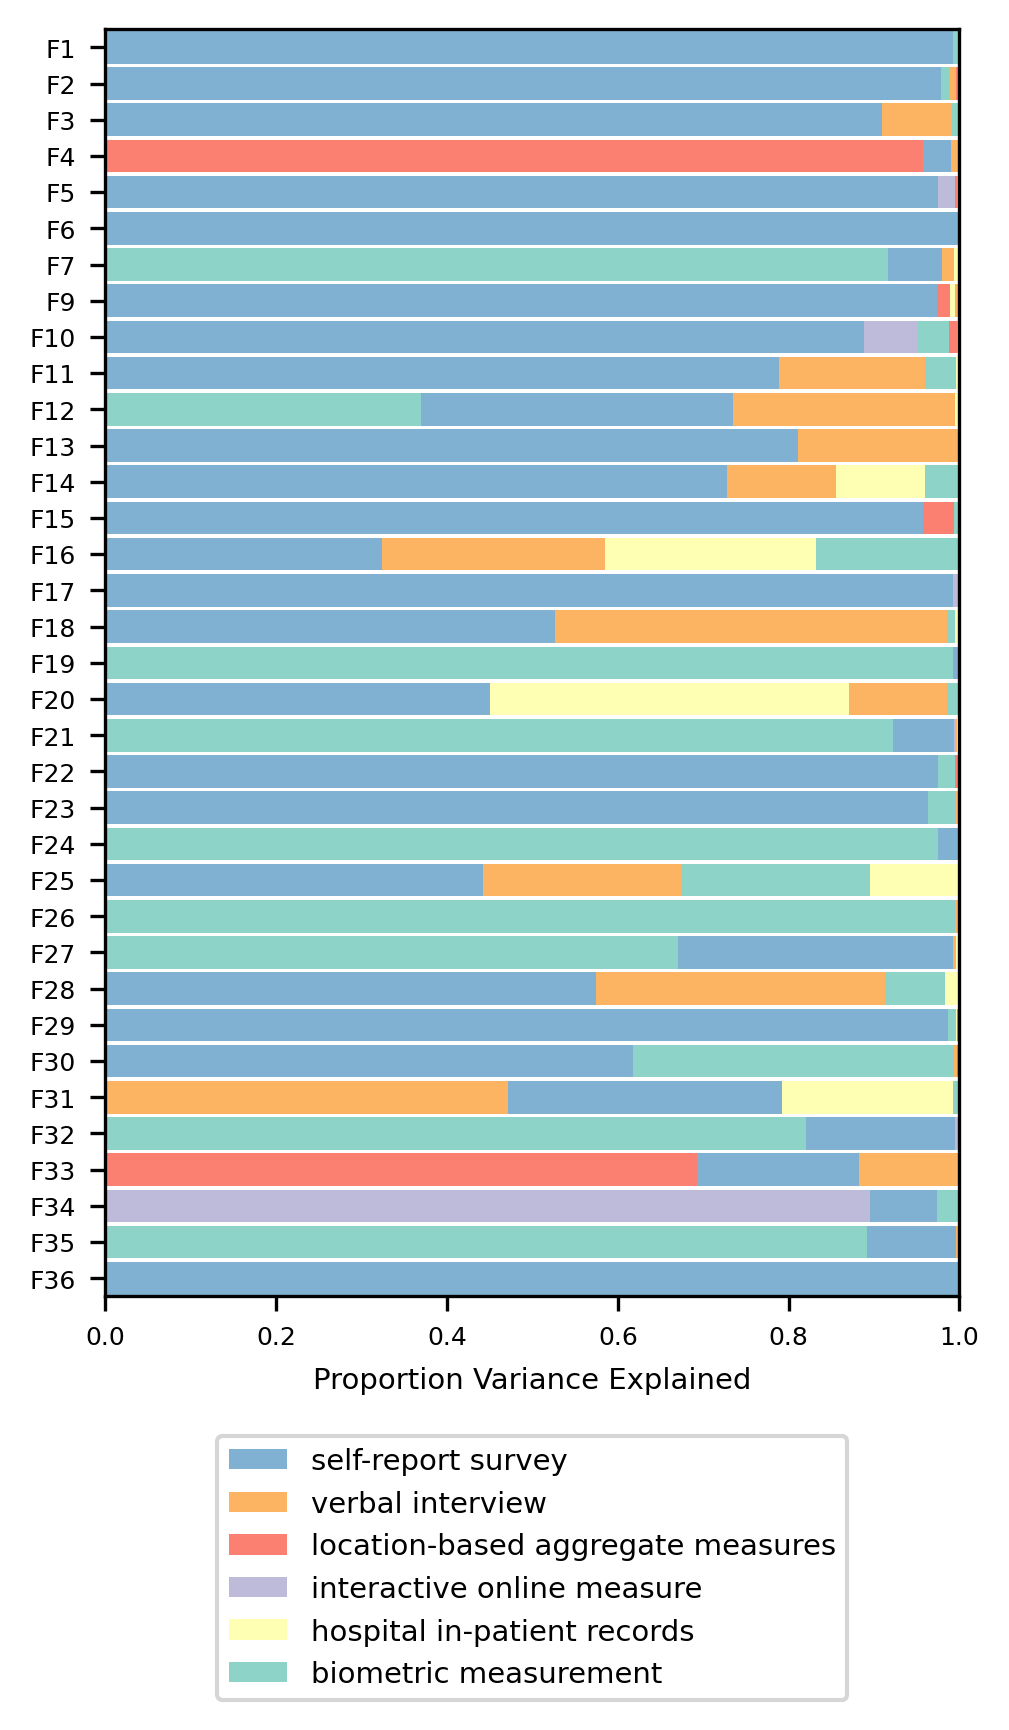

In [111]:
fig, ax1 = plt.subplots(figsize=(3.464,6),dpi=300)
mydf=pctvar.T.loc[::-1]
x = mydf.index
indexes = np.argsort(mydf.values).T
widths = np.sort(mydf.values).T
order = -1
lefts = widths[::order].cumsum(axis=0)
lefts = np.insert(lefts, 0, np.zeros(len(lefts[0])), axis=0)

mpp_colors = dict(zip(mydf.columns, plt.cm.get_cmap("Set3").colors))
#mpp_colors["self-reported health & medical history"] = plt.cm.get_cmap("Set3").colors[11]

for k, (idxs, vals) in enumerate(list(zip(indexes, widths))[::order]):
    mps = np.take(np.array(mydf.columns), idxs)
    ax1.barh(x, width=vals, height=0.9,left=lefts[k], color=[mpp_colors[m] for m in mps])
    
ax1.legend((np.take(np.array(mydf.columns), np.argsort(mydf.values)[0]))[::-1], bbox_to_anchor=(0.5, -0.33), loc='lower center', fontsize=7)
ax1.set_xlim([0,1])
ax1.set_ylim([-0.5,34.5])
ax1.tick_params(axis='both', which='major', labelsize=6)

fig.tight_layout()

plt.xlabel("Proportion Variance Explained",fontsize=7)
plt.savefig("/stanley/robinson/ccarey/factor_paper_revision/edfigs_CEC/EDFig2.eps") #,bbox_inches="tight")